In this notebook, I use **Xception** pre-trained model to do artistic style transfer.

The idea of artistic style transfer is to obtain a representation of the style of an input image and apply the style to another image while keeping the original image content recognizable.

## Dependencties

In [1]:
import time
import numpy as np
import tensorflow.contrib.keras.api.keras.backend as K
from scipy.misc import imsave, imresize
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import xception
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
%matplotlib inline

## Define Constants

In [259]:
# image file path
CONTENT_IMG_PATH= 'glass_church.jpg'
STYLE_IMG_PATH = 'oil.jpg'
# if want to keep tarining a previous image, change CONTENT_IMG_PATH to the previous image path
START_IMG_PATH = CONTENT_IMG_PATH 

# Number of iterations to run
ITER = 10

# Weights of losses
CONTENT_WEIGHT = 50
STYLE_WEIGHT = 1e6
TV_WEIGHT = 100

# Define the shape of the otput image
w, h = load_img(CONTENT_IMG_PATH).size
print('content_img width and height:', w,h)
img_h = 400
img_w = int(w * img_h / h)
print('gen_img width and height:', img_w, img_h)

content_img width and height: 660 371
gen_img width and height: 711 400


## Visualize content and style image

In [3]:
def visualize_image(img_path):
    img = plt.imread(img_path)
    plt.xticks([])
    plt.yticks([])
    plt.title(img.shape)
    plt.imshow(img);

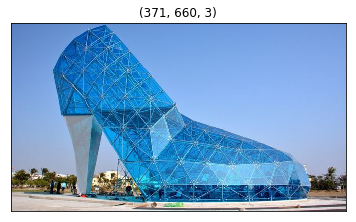

In [215]:
visualize_image(CONTENT_IMG_PATH)

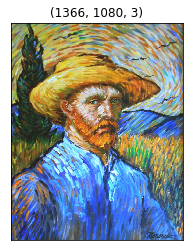

In [216]:
visualize_image(STYLE_IMG_PATH)

## Pre-process the Data

In [6]:
def preprocess(img_path):
    # loads RGB image from img_path
    img = load_img(img_path)
    # convert the image pixels to a numpy array
    img = img_to_array(img)
    # reshape array to 3D tensor
    img = imresize(img, (img_h, img_w, 3))
    img = img.astype('float64')
    # convert 3D tensor to 4D tensor 
    img = np.expand_dims(img, axis=0)
    # prepare the image for the VGG model
    img = xception.preprocess_input(img)
    return img

## Build the model

The input_tensor's shape is (3, height, width, channels or filters).

    * input_tensor[0]: content_img
    * input_tensor[1]: the style_img
    * input_tensor[2]: the gen_img

In [260]:
content_img = K.variable(preprocess(CONTENT_IMG_PATH))
style_img = K.variable(preprocess(STYLE_IMG_PATH))
gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

# combines three arrays into a single array 
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


In [261]:
# we are only interested in the convolutional layers which are the feature extraction layers =>
# include_top=False
model = xception.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('Model loaded')

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded


In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (3, 400, 266, 3)     0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (3, 199, 132, 32)    864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (3, 199, 132, 32)    128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (3, 199, 132, 32)    0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Xception architecture

<img src='assets/Xception_architecture.png' alt="Xception architecture">

<img src='assets/Xception2.png'>

## Calculate losses

### 1. Content loss

The content loss is the Mean Squared Error of the feature activation in the content image and the generated image.

In [10]:
def calc_content_loss(outputs_dict, content_layer_names):
    loss = 0. # initialize loss
    for name in content_layer_names:
        layer_features = outputs_dict[name]
        content_img_features = layer_features[0, :, :, :]
        gen_img_features = layer_features[2, :, :, :]
        loss += K.sum(K.square(gen_img_features - content_img_features))/len(content_layer_names)
    return loss

In [264]:
content_layer_names = ['block14_sepconv1','block14_sepconv2']
content_loss = calc_content_loss(outputs_dict, content_layer_names)

### 2. Style loss

The style loss is the Squared Error for the Gram-matrices in the style layers.

When style features and generated features have similar Gram matrices, they have similar styles.

In [12]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def calc_style_loss(outputs_dict, feature_layer_names):
    style_loss = 0.
    for name in feature_layer_names:
        layer_features = outputs_dict[name]
        style_features = layer_features[1, :, :, :]
        gen_img_features = layer_features[2, :, :, :]
        
        assert K.ndim(style_features) == 3
        assert K.ndim(gen_img_features) == 3
        S = gram_matrix(style_features)
        G = gram_matrix(gen_img_features)
        channels = 3
        size = img_h * img_w
        style_loss += (K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2)))/len(feature_layer_names)
    return style_loss

In [265]:
# for glass church
feature_layer_names = ['block1_conv1', 'block1_conv2',
                       'block2_sepconv1', 'block2_sepconv2',
                       'block3_sepconv1', 'block3_sepconv2', 
                       'block4_sepconv1', 'block4_sepconv2',
                       'block5_sepconv1', 'block5_sepconv2', 'block5_sepconv3', 
                       'block6_sepconv1', 'block6_sepconv2', 'block6_sepconv3', 
                       'block7_sepconv1', 'block7_sepconv2', 'block7_sepconv3', 
                       'block8_sepconv1', 'block8_sepconv2', 'block8_sepconv3', 
                       'block9_sepconv1', 'block9_sepconv2', 'block9_sepconv3', 
                       'block10_sepconv1', 'block10_sepconv2', 'block10_sepconv3', 
                       'block11_sepconv1', 'block11_sepconv2', 'block11_sepconv3', 
                       'block12_sepconv1', 'block12_sepconv2', 'block12_sepconv3']
style_loss = calc_style_loss(outputs_dict, feature_layer_names)

In [255]:
# for people
feature_layer_names = ['block1_conv2',
                       'block5_sepconv1', 'block5_sepconv3',  
                       'block7_sepconv1', 'block7_sepconv3', 
                       'block9_sepconv1', 'block9_sepconv3', 
                       'block10_sepconv1', 'block10_sepconv3', 
                       'block11_sepconv1', 'block11_sepconv3', 
                       'block12_sepconv1', 'block12_sepconv3']
style_loss = calc_style_loss(outputs_dict, feature_layer_names)

### 3. Total variance loss

The total variance loss is the difference between the neighboring pixel values.

Penalize wiggles or variation in the pixel values to smooth the generated image. 

In [14]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    row_diff = K.square(x[:,:-1,:-1,:] - x[:,1:  , :-1,:])
    col_diff = K.square(x[:,:-1,:-1,:] - x[:, :-1,1:  ,:])
    return K.sum(K.pow(row_diff + col_diff, 1.25))

In [266]:
variation_loss= total_variation_loss(gen_img)
loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss + TV_WEIGHT * variation_loss

## Evaluating the gradients and loss

In [267]:
grads = K.gradients(loss, gen_img)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_output = K.function([gen_img], outputs)


def eval_loss_and_grads(x):
    x = x.reshape((1, img_h, img_w, 3))

    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

## Deprocess the image

Do the reverse of the preprocessing to display the generated image.

For Xception model, it will use the **mode == 'tf'** for preprocess the data.

According to [imagenet_utils.py](https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py), we need to add 1 and multiply 127.5 back for each pixel in each channel before outputing the generated image.

**Note**: Adding the mean pixel value back just like vgg19 model doesn't work for Xception model. It will show a grayscale image.


```python
# function in imagenet_utils.py
def _preprocess_numpy_input(x, data_format, mode, **kwargs):

    backend, _, _, _ = get_submodules_from_kwargs(kwargs)
    if not issubclass(x.dtype.type, np.floating):
        x = x.astype(backend.floatx(), copy=False)

    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x

    if mode == 'torch':
        x /= 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if x.ndim == 3:
                x = x[::-1, ...]
            else:
                x = x[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            x = x[..., ::-1]
        mean = [103.939, 116.779, 123.68]
        std = None

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] -= mean[0]
            x[1, :, :] -= mean[1]
            x[2, :, :] -= mean[2]
            if std is not None:
                x[0, :, :] /= std[0]
                x[1, :, :] /= std[1]
                x[2, :, :] /= std[2]
        else:
            x[:, 0, :, :] -= mean[0]
            x[:, 1, :, :] -= mean[1]
            x[:, 2, :, :] -= mean[2]
            if std is not None:
                x[:, 0, :, :] /= std[0]
                x[:, 1, :, :] /= std[1]
                x[:, 2, :, :] /= std[2]
    else:
        x[..., 0] -= mean[0]
        x[..., 1] -= mean[1]
        x[..., 2] -= mean[2]
        if std is not None:
            x[..., 0] /= std[0]
            x[..., 1] /= std[1]
            x[..., 2] /= std[2]
    return x
```

In [17]:
def unprocess_image(img):
    if K.image_data_format() == 'channels_first':
        # For Theano
        img = img.reshape((3, img_h, img_w))
        img = img.transpose((1, 2, 0))
    else:
        # tf as backend: batch, height, width, depth
        img = img.reshape((img_h, img_w, 3))
        
    img = (img + 1.)*127.5
    img = np.clip(img, 0, 255).astype('uint8')
    return img

## Train and Run the model

In [18]:
def train(save_weights_path):
    evaluator = Evaluator()
    x = preprocess(START_IMG_PATH)
    result_prefix = 'gen_img'
    for i in range(ITER):
        print('Start of iteration', i)
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
        print('Current loss value:', min_val)
        # save current generated image
        img = unprocess_image(x.copy())
        fname = result_prefix + '_at_iteration_%d.png' % i
        imsave(fname, img)
        visualize_image(fname)
        end_time = time.time()
        print('Iteration %d completed in %ds' % (i, end_time - start_time))
    model.save_weights(save_weights_path)

=====================================================================================================================
### || Glass Church - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 50 
    - STYLE_WEIGHT = 1e6 
    - TV_WEIGHT = 100
    
transfer style: **oil paiting**

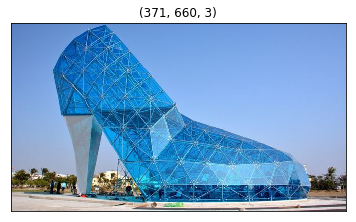

In [223]:
# content image
visualize_image('glass_church.jpg')

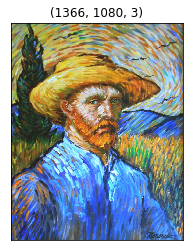

In [225]:
# style image
visualize_image('oil.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 16189235.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Iteration 0 completed in 568s
Start of iteration 1
Current loss value: 9999452.0
Iteration 1 completed in 505s
Start of iteration 2
Current loss value: 7746293.0
Iteration 2 completed in 524s
Start of iteration 3
Current loss value: 6283024.5
Iteration 3 completed in 616s
Start of iteration 4
Current loss value: 5190999.0
Iteration 4 completed in 601s
Start of iteration 5
Current loss value: 4365841.0
Iteration 5 completed in 598s
Start of iteration 6
Current loss value: 3760977.8
Iteration 6 completed in 534s
Start of iteration 7
Current loss value: 3287217.5
Iteration 7 completed in 554s
Start of iteration 8
Current loss value: 2925296.5
Iteration 8 completed in 538s
Start of iteration 9
Current loss value: 2668481.0
Iteration 9 completed in 518s


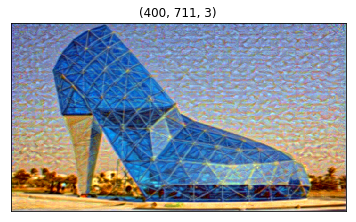

In [268]:
save_weights_path = 'save_model/Xoil_model_weights.hdf5'
train(save_weights_path)

=====================================================================================================================
### || Glass Church - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 100 
    - STYLE_WEIGHT = 10000 
    - TV_WEIGHT = 10
    
transfer style: **doodle art**

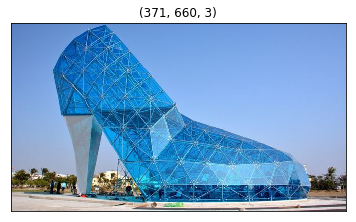

In [36]:
# content image
visualize_image('glass_church.jpg')

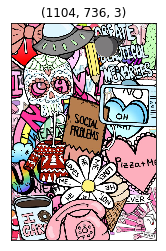

In [65]:
# style image
visualize_image('doodle2.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 2075021.9


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Iteration 0 completed in 522s
Start of iteration 1
Current loss value: 1724879.5
Iteration 1 completed in 483s
Start of iteration 2
Current loss value: 1382484.6
Iteration 2 completed in 484s
Start of iteration 3
Current loss value: 1194773.8
Iteration 3 completed in 566s
Start of iteration 4
Current loss value: 1046027.1
Iteration 4 completed in 573s
Start of iteration 5
Current loss value: 950473.5
Iteration 5 completed in 570s
Start of iteration 6
Current loss value: 889724.5
Iteration 6 completed in 536s
Start of iteration 7
Current loss value: 844502.06
Iteration 7 completed in 559s
Start of iteration 8
Current loss value: 812893.3
Iteration 8 completed in 497s
Start of iteration 9
Current loss value: 787685.2
Iteration 9 completed in 507s


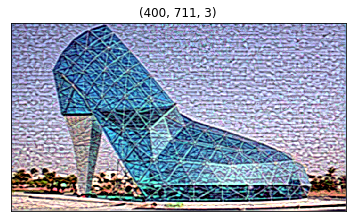

In [57]:
save_weights_path = 'save_model/Xdoodle_model_weights.hdf5'
train(save_weights_path)

## Retrain the model

1. Reload the saved model weights
2. Change the start image to the image we wants to keep training

In [58]:
# Load model weights
model.load_weights('save_model/Xdoodle_model_weights.hdf5')

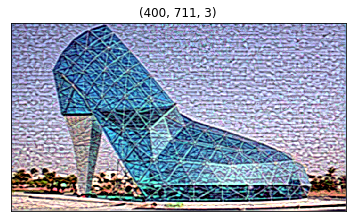

In [61]:
START_IMG_PATH = 'previous_img.png'
visualize_image(START_IMG_PATH)

### || Glass Church - iteration 11-20 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 100 
    - STYLE_WEIGHT = 10000 
    - TV_WEIGHT = 10

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 899461.4


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Iteration 0 completed in 514s
Start of iteration 1
Current loss value: 823627.9
Iteration 1 completed in 509s
Start of iteration 2
Current loss value: 772718.25
Iteration 2 completed in 575s
Start of iteration 3
Current loss value: 741370.5
Iteration 3 completed in 586s
Start of iteration 4
Current loss value: 716453.25
Iteration 4 completed in 634s
Start of iteration 5
Current loss value: 700210.4
Iteration 5 completed in 603s
Start of iteration 6
Current loss value: 687047.06
Iteration 6 completed in 558s
Start of iteration 7
Current loss value: 674399.5
Iteration 7 completed in 498s
Start of iteration 8
Current loss value: 663507.8
Iteration 8 completed in 457s
Start of iteration 9
Current loss value: 655721.06
Iteration 9 completed in 442s


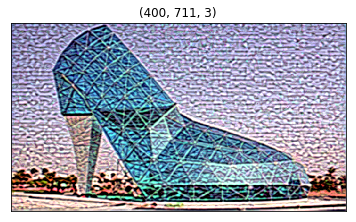

In [62]:
save_weights_path = 'save_model/Xdoodle_model_weights_20.hdf5'
train(save_weights_path)

=====================================================================================================================
### || Glass Church - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 100 
    - STYLE_WEIGHT = 50000 
    - TV_WEIGHT = 10
    
transfer style: **sketch**

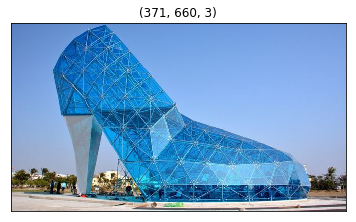

In [113]:
# content image
visualize_image('glass_church.jpg')

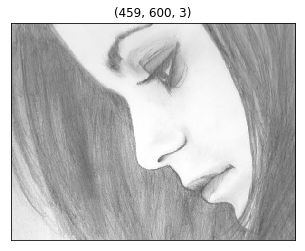

In [89]:
# style image
visualize_image('face_sketch.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 1390821.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Iteration 0 completed in 622s
Start of iteration 1
Current loss value: 1014098.6
Iteration 1 completed in 646s
Start of iteration 2
Current loss value: 802528.25
Iteration 2 completed in 649s
Start of iteration 3
Current loss value: 652129.94
Iteration 3 completed in 626s
Start of iteration 4
Current loss value: 556780.8
Iteration 4 completed in 674s
Start of iteration 5
Current loss value: 484306.28
Iteration 5 completed in 668s
Start of iteration 6
Current loss value: 437463.22
Iteration 6 completed in 662s
Start of iteration 7
Current loss value: 396837.75
Iteration 7 completed in 697s
Start of iteration 8
Current loss value: 366968.62
Iteration 8 completed in 620s
Start of iteration 9
Current loss value: 342283.2
Iteration 9 completed in 598s


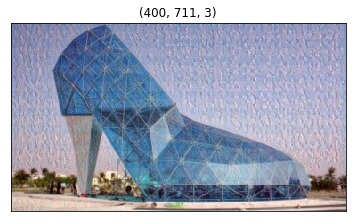

In [90]:
save_weights_path = 'save_model/Xsketch_model_weights.hdf5'
train(save_weights_path)

### || Glass Church - iteration 11-20 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 100 
    - STYLE_WEIGHT = 50000 
    - TV_WEIGHT = 10

In [93]:
# Load model weights
model.load_weights('save_model/Xsketch_model_weights.hdf5')

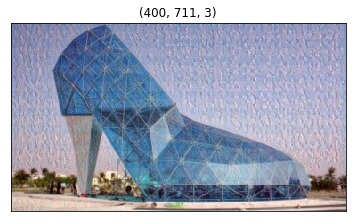

In [94]:
START_IMG_PATH = 'previous_img.png'
visualize_image(START_IMG_PATH)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 323583.9


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Iteration 0 completed in 694s
Start of iteration 1
Current loss value: 306608.9
Iteration 1 completed in 563s
Start of iteration 2
Current loss value: 291639.2
Iteration 2 completed in 581s
Start of iteration 3
Current loss value: 279329.4
Iteration 3 completed in 649s
Start of iteration 4
Current loss value: 269414.28
Iteration 4 completed in 581s
Start of iteration 5
Current loss value: 260728.97
Iteration 5 completed in 600s
Start of iteration 6
Current loss value: 252585.34
Iteration 6 completed in 573s
Start of iteration 7
Current loss value: 245800.0
Iteration 7 completed in 668s
Start of iteration 8
Current loss value: 238075.84
Iteration 8 completed in 622s
Start of iteration 9
Current loss value: 231722.45
Iteration 9 completed in 573s


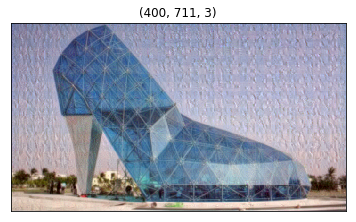

In [95]:
save_weights_path = 'save_model/Xsketch_model_weights_20.hdf5'
train(save_weights_path)

=====================================================================================================================
### || People - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 1 
    - STYLE_WEIGHT = 1e4
    - TV_WEIGHT = 5
    
transfer style: **people painting**

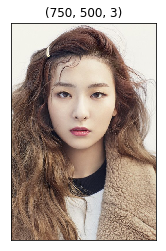

In [303]:
# content image
visualize_image('seulgi.jpg')

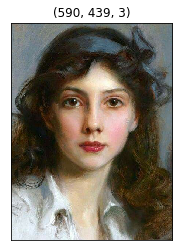

In [222]:
# style image
visualize_image('people-painting.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 85815.5
Iteration 0 completed in 140s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Current loss value: 72297.59
Iteration 1 completed in 115s
Start of iteration 2
Current loss value: 61526.434
Iteration 2 completed in 108s
Start of iteration 3
Current loss value: 53459.875
Iteration 3 completed in 107s
Start of iteration 4
Current loss value: 45984.785
Iteration 4 completed in 130s
Start of iteration 5
Current loss value: 40438.49
Iteration 5 completed in 118s
Start of iteration 6
Current loss value: 35381.51
Iteration 6 completed in 112s
Start of iteration 7
Current loss value: 31502.166
Iteration 7 completed in 107s
Start of iteration 8
Current loss value: 28339.379
Iteration 8 completed in 108s
Start of iteration 9
Current loss value: 26053.87
Iteration 9 completed in 115s


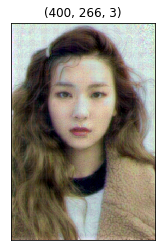

In [80]:
save_weights_path = 'save_model/Xpeople_model_weights_10.hdf5'
train(save_weights_path)

### || People - iteration 11-30 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 1 
    - STYLE_WEIGHT = 1e4
    - TV_WEIGHT = 5

In [88]:
START_IMG_PATH = 'previous_img.png'

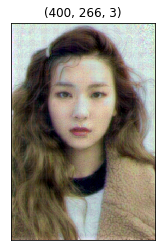

In [89]:
visualize_image(START_IMG_PATH)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 23554.209
Iteration 0 completed in 110s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Current loss value: 21887.076
Iteration 1 completed in 103s
Start of iteration 2
Current loss value: 20685.457
Iteration 2 completed in 105s
Start of iteration 3
Current loss value: 19607.117
Iteration 3 completed in 109s
Start of iteration 4
Current loss value: 18515.793
Iteration 4 completed in 107s
Start of iteration 5
Current loss value: 17596.145
Iteration 5 completed in 110s
Start of iteration 6
Current loss value: 16777.229
Iteration 6 completed in 109s
Start of iteration 7
Current loss value: 15953.459
Iteration 7 completed in 108s
Start of iteration 8
Current loss value: 15241.309
Iteration 8 completed in 114s
Start of iteration 9
Current loss value: 14484.283
Iteration 9 completed in 110s
Start of iteration 10
Current loss value: 13878.827
Iteration 10 completed in 125s
Start of iteration 11
Current loss value: 13308.252
Iteration 11 completed in 124s
Start of iteration 12
Current loss value: 12752.445
Iteration 12 completed in 110s
Start of iteration 13
Current loss value: 1

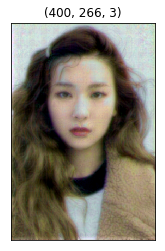

In [91]:
save_weights_path = 'save_model/Xpeople_model_weights_30.hdf5'
train(save_weights_path)


### || People - iteration 30-60 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 1
    - STYLE_WEIGHT = 1e4
    - TV_WEIGHT = 5

In [126]:
model.load_weights('save_model/Xpeople_model_weights_30.hdf5')

In [127]:
START_IMG_PATH = 'previous_img.png'

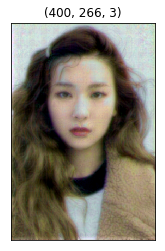

In [128]:
visualize_image(STAET_IMG_PATH)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 9752.473
Iteration 0 completed in 119s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Current loss value: 9360.934
Iteration 1 completed in 119s
Start of iteration 2
Current loss value: 9061.119
Iteration 2 completed in 116s
Start of iteration 3
Current loss value: 8673.199
Iteration 3 completed in 119s
Start of iteration 4
Current loss value: 8368.018
Iteration 4 completed in 130s
Start of iteration 5
Current loss value: 8183.798
Iteration 5 completed in 113s
Start of iteration 6
Current loss value: 8006.7715
Iteration 6 completed in 137s
Start of iteration 7
Current loss value: 7820.9595
Iteration 7 completed in 136s
Start of iteration 8
Current loss value: 7637.6943
Iteration 8 completed in 118s
Start of iteration 9
Current loss value: 7489.1074
Iteration 9 completed in 118s
Start of iteration 10
Current loss value: 7344.4395
Iteration 10 completed in 128s
Start of iteration 11
Current loss value: 7177.5186
Iteration 11 completed in 117s
Start of iteration 12
Current loss value: 7013.249
Iteration 12 completed in 129s
Start of iteration 13
Current loss value: 6881.37

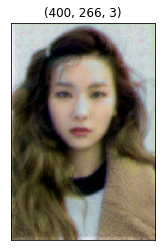

In [129]:
save_weights_path = 'save_model/Xpeople_model_weights_60.hdf5'
train(save_weights_path)

=====================================================================================================================
### || People - iteration 61-80 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 5
    - STYLE_WEIGHT = 2e5
    - TV_WEIGHT = 5

In [196]:
START_IMG_PATH = 'previous_img.png'

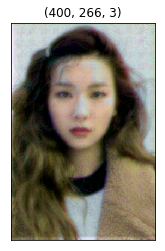

In [197]:
visualize_image(START_IMG_PATH)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 43677.223
Iteration 0 completed in 125s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Current loss value: 39631.79
Iteration 1 completed in 102s
Start of iteration 2
Current loss value: 36747.71
Iteration 2 completed in 104s
Start of iteration 3
Current loss value: 34598.703
Iteration 3 completed in 112s
Start of iteration 4
Current loss value: 32914.133
Iteration 4 completed in 103s
Start of iteration 5
Current loss value: 31455.033
Iteration 5 completed in 105s
Start of iteration 6
Current loss value: 30107.604
Iteration 6 completed in 107s
Start of iteration 7
Current loss value: 28927.102
Iteration 7 completed in 119s
Start of iteration 8
Current loss value: 27997.365
Iteration 8 completed in 114s
Start of iteration 9
Current loss value: 27219.414
Iteration 9 completed in 119s
Start of iteration 10
Current loss value: 26564.188
Iteration 10 completed in 118s
Start of iteration 11
Current loss value: 25818.334
Iteration 11 completed in 115s
Start of iteration 12
Current loss value: 25191.408
Iteration 12 completed in 122s
Start of iteration 13
Current loss value: 244

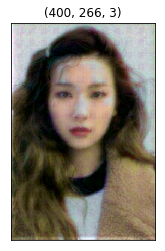

In [198]:
save_weights_path = 'save_model/Xpeople_model_weights_80_2.hdf5'
train(save_weights_path)

=====================================================================================================================
### || People - iteration 81-100 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 5
    - STYLE_WEIGHT = 2e5
    - TV_WEIGHT = 5

In [208]:
model.load_weights('save_model/Xpeople_model_weights_80_2.hdf5')

In [209]:
START_IMG_PATH = 'previous_img.png'

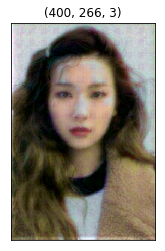

In [210]:
visualize_image(START_IMG_PATH)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 21254.334
Iteration 0 completed in 125s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


Current loss value: 20714.598
Iteration 1 completed in 109s
Start of iteration 2
Current loss value: 20299.75
Iteration 2 completed in 107s
Start of iteration 3
Current loss value: 19981.877
Iteration 3 completed in 105s
Start of iteration 4
Current loss value: 19713.31
Iteration 4 completed in 103s
Start of iteration 5
Current loss value: 19474.62
Iteration 5 completed in 114s
Start of iteration 6
Current loss value: 19255.91
Iteration 6 completed in 104s
Start of iteration 7
Current loss value: 19036.75
Iteration 7 completed in 108s
Start of iteration 8
Current loss value: 18806.094
Iteration 8 completed in 105s
Start of iteration 9
Current loss value: 18548.297
Iteration 9 completed in 103s
Start of iteration 10
Current loss value: 18322.865
Iteration 10 completed in 109s
Start of iteration 11
Current loss value: 18142.586
Iteration 11 completed in 101s
Start of iteration 12
Current loss value: 17974.65
Iteration 12 completed in 103s
Start of iteration 13
Current loss value: 17685.3

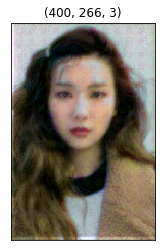

In [211]:
save_weights_path = 'save_model/Xpeople_model_weights_100_2.hdf5'
train(save_weights_path)

## Reference

1. [Review: Xception — With Depthwise Separable Convolution, Better Than Inception-v3 (Image Classification)](https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568)
2. [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/pdf/1610.02357.pdf)
3. [Depth-wise Convolution and Depth-wise Separable Convolution](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)